In [3]:
import os
import shutil
import random
from torchvision import datasets, models
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import models
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score


print(torch.__version__)
print(torchvision.__version__)

2.5.0
0.20.0


### Загрузим данные и раскидаем все по train, val, test

In [4]:
raw_dataset = './raw_data'
splitted_dataset = './splitted_data'

In [5]:
if not os.path.exists(splitted_dataset):
    os.mkdir(splitted_dataset)

In [6]:
train_dir = os.path.join(splitted_dataset, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

In [7]:
val_dir = os.path.join(splitted_dataset, 'val')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)

In [8]:
test_dir = os.path.join(splitted_dataset, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [9]:
#classes = ['glioma', 'healthy', 'meningioma', 'pituitary']
classes = [d for d in os.listdir(raw_dataset) if os.path.isdir(os.path.join(raw_dataset, d))]
print(classes)

['pituitary', 'healthy', 'glioma', 'meningioma']


In [10]:
#make folders for each class inside each bucket (train val test)
for cls in classes:
    train_full = os.path.join(train_dir, cls)
    if not os.path.exists(train_full):
        os.mkdir(train_full)

    val_full = os.path.join(val_dir, cls)
    if not os.path.exists(val_full):
        os.mkdir(val_full)
    
    test_full = os.path.join(test_dir, cls)
    if not os.path.exists(test_full):
        os.mkdir(test_full)

In [11]:
# разделим наши файлы по train test val
for cls in classes:
    cls_dir = os.path.join(raw_dataset, cls)
    files = [f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))]

    #проверим не пустая ли папка
    if len(files) == 0:
        print(f'В папке {os.path(cls_dir)} нет файлов')
        continue
    
    random.seed(42)
    random.shuffle(files)
    # определяем сколько файлов по трейн валу и тесту будем кидать в процентах
    train_split = int(0.7 * len(files))
    val_split = int(0.2 * len(files))
    test_split = int(0.1 * len(files))

    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    print(f'Class {cls}')
    print(f'Total files: {len(files)}')
    print(f'Train_split: {len(train_files)}')
    print(f'Validation_split: {len(val_files)}')
    print(f'Test_split: {len(test_files)}')

    #теперь скопируем файлы из оригинальной папки в эту сложную систему папок, накатаем функцию
    def copy_files(file_list, src_dir, dst_dir):
        for file in file_list:
            src = os.path.join(src_dir, file)
            dst = os.path.join(dst_dir, cls, file)
            shutil.copyfile(src, dst)
    
    copy_files(train_files, cls_dir, train_dir)
    copy_files(val_files, cls_dir, val_dir)
    copy_files(test_files, cls_dir, test_dir)
    
    print("Разделение данных завершено")


Class pituitary
Total files: 1757
Train_split: 1229
Validation_split: 351
Test_split: 177
Разделение данных завершено
Class healthy
Total files: 2000
Train_split: 1400
Validation_split: 400
Test_split: 200
Разделение данных завершено
Class glioma
Total files: 1621
Train_split: 1134
Validation_split: 324
Test_split: 163
Разделение данных завершено
Class meningioma
Total files: 1645
Train_split: 1151
Validation_split: 329
Test_split: 165
Разделение данных завершено


### Определим свойства трансформера этих данных 

In [12]:
train_transforms = transforms.Compose([
    transforms.Resize(size =(224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 10),
    transforms.ToImage(),
    transforms.ToDtype(dtype = torch.float32, scale = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
val_transforms = transforms.Compose([
    transforms.Resize(size =(224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(dtype = torch.float32, scale = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [14]:
test_transforms = transforms.Compose([
    transforms.Resize(size =(224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(dtype = torch.float32, scale = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply Transformations


In [15]:
train_dataset = datasets.ImageFolder(root = train_dir, transform = train_transforms)
val_dataset = datasets.ImageFolder(root = val_dir, transform = val_transforms)
test_dataset = datasets.ImageFolder(root = test_dir, transform = test_transforms)

In [16]:
# Проверка классов
print("Классы:", train_dataset.classes)

Классы: ['glioma', 'healthy', 'meningioma', 'pituitary']


# Создадим даталоадеры что бы иметь удобную настройку batch size, многопоточность при загрузке

In [17]:
batch_size = 64
num_workers = 8

In [18]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)


In [19]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: mps


In [20]:
model = models.resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT)

In [21]:
num_classes = len(train_dataset.classes)
num_ftrs = model.fc.in_features
print(f'Model specs:\n============\nNum classes: {num_classes}\nNum Features: {num_ftrs}')

Model specs:
Num classes: 4
Num Features: 2048


In [22]:
model.fc = torch.nn.Linear(num_ftrs, num_classes)

In [23]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Модель только со всеми замороженными параметрами кроме параметров FC

In [24]:
for parameter in model.parameters():
    parameter.requires_grad = False
for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [25]:
model = model.to(device)

In [26]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr = 0.001, momentum = 0.9)


##### Loss Function

In [27]:
criterion = torch.nn.CrossEntropyLoss()

##### Функция обучения


In [28]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []  # Список для хранения предсказанных классов
    all_labels = []  # Список для хранения истинных меток

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs= model(inputs) ### прямой проход
        loss = criterion(outputs, labels) ### рассчет функции потерь
        loss.backward() ### обратный проход
        optimizer.step() ### обновление параметров

        running_loss += loss.item() * inputs.size(0) # возвращает первую ось тензора где сожержится размер батча, например тензор изначально как
                                                    # (64, 3, 224, 224) и возьмется соответсвенно 64
        _, preds= torch.max(outputs, 1) # возвращает 2 объекта - первый реальный probability максимальный из всех классов, второй индекс класса (или просто класс)
        correct += (preds == labels).sum().item() # предсказания равны лейблам, сумма, превратить в число из тензора
        total += labels.size(0) # количество лейблов по сути, а именно 


    epoch_loss = running_loss/total # средняя потеря за эпоху в виде накопишвегося лосс поделить на общее количество примеров
    epoch_acc = correct/total # точность

    return epoch_loss, epoch_acc # Возвращаем метрики



In [29]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval() #переводим модель в режим оценки
    running_loss = 0.0
    correct = 0 
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            # Вычисление точности
            _, preds = torch.max(outputs, 1)  # Получаем предсказанные классы
            correct += (preds == labels).sum().item()  # Считаем правильные предсказания
            total += labels.size(0)  # Общее количество образцов

    epoch_loss = running_loss / total  # Средняя потеря за эпоху
    epoch_acc = correct / total        # Точность за эпоху

    return epoch_loss, epoch_acc  # Возвращаем потери и точность

In [30]:
num_epochs = 20
history = {
    'train_loss':[],
    'train_acc':[],
    'val_loss':[],
    'val_acc':[]
}
best_val_acc = 0.0

In [31]:
import time

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Обучение одной эпохи
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    # Валидация на одной эпохе
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f'Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1/20
----------
Train Loss: 1.2437 Acc: 0.5299
Validation Loss: 1.1187 Acc: 0.6296
Epoch 1 duration: 124.99 seconds
Epoch 2/20
----------
Train Loss: 0.9793 Acc: 0.7629
Validation Loss: 0.9501 Acc: 0.7536
Epoch 2 duration: 125.11 seconds
Epoch 3/20
----------
Train Loss: 0.8435 Acc: 0.7821
Validation Loss: 0.8270 Acc: 0.8070
Epoch 3 duration: 124.87 seconds
Epoch 4/20
----------
Train Loss: 0.7498 Acc: 0.8046
Validation Loss: 0.7523 Acc: 0.8234
Epoch 4 duration: 125.06 seconds
Epoch 5/20
----------
Train Loss: 0.6944 Acc: 0.8136
Validation Loss: 0.7176 Acc: 0.8226
Epoch 5 duration: 125.33 seconds
Epoch 6/20
----------
Train Loss: 0.6429 Acc: 0.8274
Validation Loss: 0.6995 Acc: 0.8212
Epoch 6 duration: 125.17 seconds
Epoch 7/20
----------
Train Loss: 0.6086 Acc: 0.8301
Validation Loss: 0.6558 Acc: 0.8219
Epoch 7 duration: 124.96 seconds
Epoch 8/20
----------
Train Loss: 0.5871 Acc: 0.8282
Validation Loss: 0.6113 Acc: 0.8355
Epoch 8 duration: 125.05 seconds
Epoch 9/20
----------
Tr

In [32]:
# Загрузим лучшие полученные параметры модели
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print(f'Best accuracy on validation {best_val_acc:.4f}')

Best accuracy on validation 0.8668


Resnet 15 Best accuracy on validation 0.8868


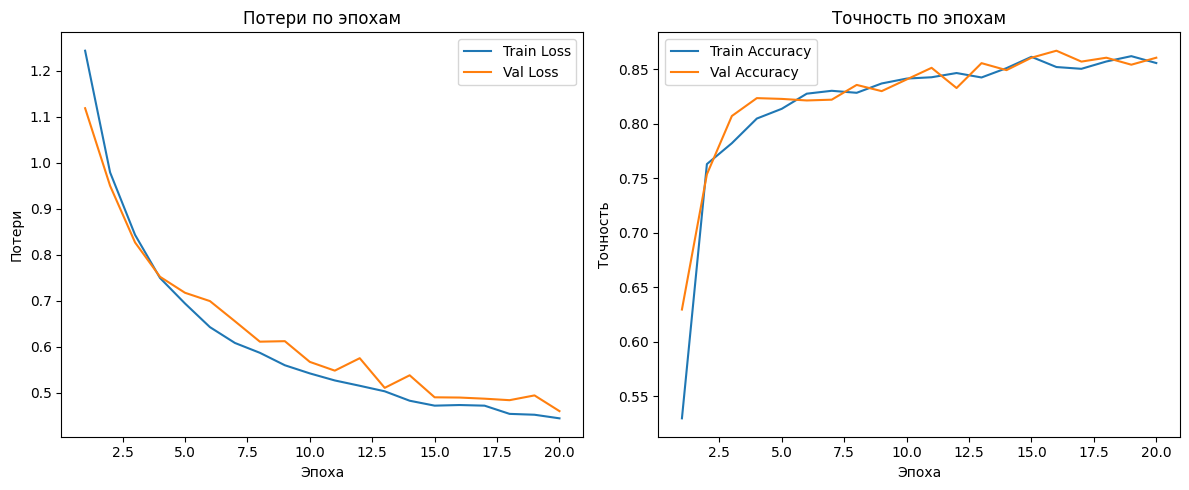

In [33]:
# Визуализация
plt.figure(figsize = (12,5))

# Потери Loss
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs + 1), history['train_loss'], label = 'Train Loss')
plt.plot(range(1, num_epochs + 1), history['val_loss'], label= 'Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери по эпохам')
plt.legend()

# Accuracy Точность
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), history['train_acc'], label='Train Accuracy')
plt.plot(range(1, num_epochs+1), history['val_acc'], label='Val Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность по эпохам')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# # сохраним нашу модель
# torch.save(model.state_dict(), 'best_model_resnet50.pth')
# print('Модель сохранена как best_model_resnet50.pth')

Модель сохранена как best_model_resnet50.pth


In [36]:
# загружаем модель
model_path = 'best_model_resnet50.pth'
model.load_state_dict(torch.load(model_path))
print(f"Модель загружена из {model_path}")

Модель загружена из best_model_resnet50.pth


/var/folders/65/q8wgn7154wzczwx33q2kvtq80000gn/T/ipykernel_6029/845845563.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [34]:
# Тестирование модели на тестовом наборе данных
test_loss, test_acc = validate_one_epoch(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

Test Loss: 0.4539 Acc: 0.8766


Test Accuracy: 0.8766
Precision: 0.8760
Recall: 0.8704
F1 Score: 0.8719


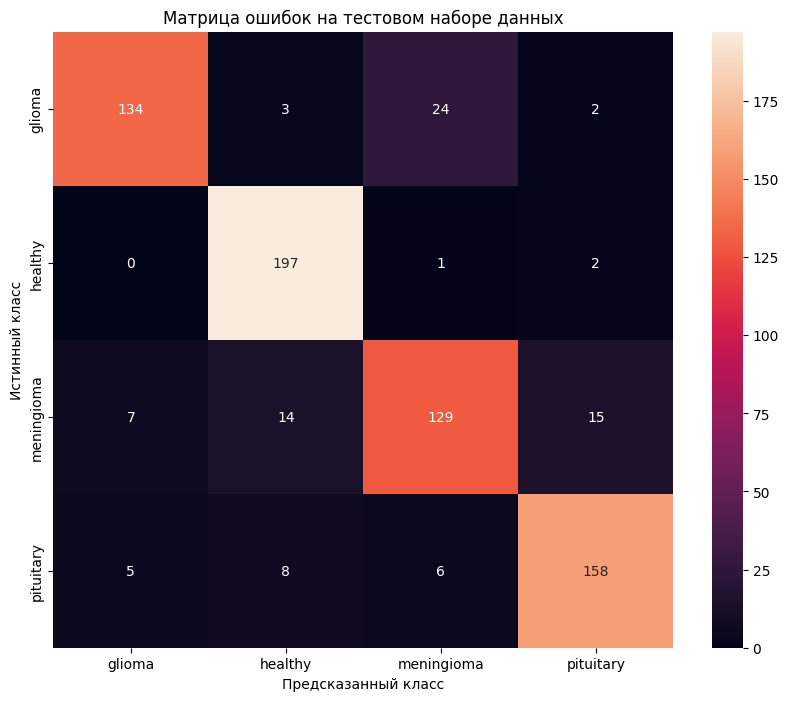

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Функция для тестирования модели на тестовом наборе данных
def test_model(model, dataloader, device):
    model.eval()  # Переводим модель в режим оценки
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Вычисляем точность
    acc = correct / total

    # Вычисляем precision, recall, f1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Test Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Вычисляем и отображаем матрицу ошибок
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок на тестовом наборе данных')
    plt.show()

# Вызываем функцию тестирования
test_model(model, test_loader, device)